# Hybrid model
We will start by loading the mesh from the previous simulation. We will then extrude this mesh and use it to solve equations that describe the connection to ice flow and fluidity in an effort to capture the temperature dependence of ice viscosity on ice flow.

In [1]:
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import geojson
import rasterio
import pygmsh
import firedrake
from firedrake import Constant, sqrt, inner, grad, dx
import icepack
from icepack.constants import (
    ice_density as ρ_I, gravity as g, weertman_sliding_law as m
)

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [52]:
outline_filename = "../mesh/amundsen.geojson"
with open(outline_filename, "r") as outline_file:
    outline = geojson.load(outline_file)

In [54]:
coords = np.array(list(geojson.utils.coords(outline)))
delta = 30e3
xmin, xmax = coords[:, 0].min() - delta, coords[:, 0].max() + delta
ymin, ymax = coords[:, 1].min() - delta, coords[:, 1].max() + delta

In [55]:
image_filename = icepack.datasets.fetch_mosaic_of_antarctica()
with rasterio.open(image_filename, "r") as image_file:
    height, width = image_file.height, image_file.width
    transform = image_file.transform
    window = rasterio.windows.from_bounds(
        left=xmin,
        bottom=ymin,
        right=xmax,
        top=ymax,
        transform=transform,
    )
    image = image_file.read(indexes=1, window=window, masked=True)

In [56]:
def subplots(*args, **kwargs):
    fig, axes = plt.subplots()
    axes.set_aspect("equal")
    xmin, ymin, xmax, ymax = rasterio.windows.bounds(window, transform)
    axes.imshow(
        image,
        cmap="Greys_r",
        vmin=12e3,
        vmax=19.38e3,
        extent=(xmin, xmax, ymin, ymax),
    )
    axes.tick_params(labelrotation=25)

    return fig, axes


In [10]:
filename = '../data/modern_state.h5'
with firedrake.CheckpointFile(filename, "r") as checkpoint:
    mesh = checkpoint.load_mesh()
    C = checkpoint.load_function(mesh, name="friction")
    u = checkpoint.load_function(mesh, name="velocity")
    h = checkpoint.load_function(mesh, name="thickness")
    bed = checkpoint.load_function(mesh, name="bed")


In [39]:
T = Constant(260.0)
A = icepack.rate_factor(T)

In [12]:
s = icepack.compute_surface(thickness=h, bed=bed)

In [17]:
Q = firedrake.FunctionSpace(mesh,family="CG",degree=2)

In [18]:
mesh3d = firedrake.ExtrudedMesh(mesh, 1)
Qc = firedrake.FunctionSpace(
    mesh3d, family='CG', degree=2, vfamily='R', vdegree=0
)
C = icepack.lift3d(C, Qc)
h = icepack.lift3d(h, Qc)
s = icepack.lift3d(s, Qc)
σx = icepack.lift3d(firedrake.interpolate(firedrake.Constant(5),Q), Qc)
σy = icepack.lift3d(firedrake.interpolate(firedrake.Constant(5),Q), Qc)

In [30]:
V0 = firedrake.VectorFunctionSpace(
    mesh3d, dim=2, family='CG', degree=2, vfamily='R', vdegree=0
)
u0 = icepack.lift3d(u, V0)

In [31]:
measures_filename = icepack.datasets.fetch_measures_antarctica()
with rasterio.open(f"netcdf:{measures_filename}:VX", "r") as vx_file, \
    rasterio.open(f"netcdf:{measures_filename}:VY", "r") as vy_file:
    u_obs = icepack.interpolate((vx_file, vy_file), V0)


In [34]:
V2 = firedrake.VectorFunctionSpace(
    mesh3d, dim=2, family='CG', degree=2, vfamily='GLL', vdegree=2
)
x, y, ζ = firedrake.SpatialCoordinate(mesh3d)
u_initial = firedrake.interpolate((1 - 0.5 * (1 - ζ)**2) * u0, V2)

In [41]:
def hybrid_friction(**kwargs):
    u = kwargs["velocity"]
    C = kwargs["friction"]
    return icepack.models.hybrid.bed_friction(velocity=u, friction=C)

In [42]:
hybrid_flow_model = icepack.models.HybridModel(friction=hybrid_friction)

In [43]:
opts = {
    'dirichlet_ids': [1, 2, 3, 4, 5],
    'diagnostic_solver_type': 'petsc',
    'diagnostic_solver_parameters': {
        'snes_type': 'newtontr',
        'pc_type': 'lu',
        'pc_factor_mat_solver_type': 'mumps'
    }
}
hybrid_flow_solver = icepack.solvers.FlowSolver(hybrid_flow_model, **opts)

In [44]:
u = hybrid_flow_solver.diagnostic_solve(
    velocity=u_initial,
    thickness=h,
    surface=s,
    fluidity=A,
    friction=C
)

In [45]:
P_0 = 1
P_1 = np.sqrt(3) * (2 * ζ - 1)
P_2 = np.sqrt(5) * (6 * ζ**2 - 6 * ζ + 1)

weight = P_0 - np.sqrt(3) * P_1 + np.sqrt(5) * P_2
u_b = icepack.depth_average(u, weight=weight)

In [48]:


weight = P_0 + np.sqrt(3) * P_1 + np.sqrt(5) * P_2
u_s = icepack.depth_average(u, weight=weight)



In [46]:
Q3d = firedrake.FunctionSpace(
    mesh3d, family='CG', degree=2, vfamily='GLL', vdegree=2
)
heat_transport = icepack.models.HeatTransport3D()

In [47]:

T = firedrake.interpolate(firedrake.Constant(260.0), Q3d)
f = firedrake.interpolate(firedrake.Constant(0.0), Q3d)
E = firedrake.interpolate(heat_transport.energy_density(T, f), Q3d)
A = icepack.rate_factor(T)


In [49]:
U_b = sqrt(inner(u_b, u_b))
U_s = sqrt(inner(u_s, u_s))
ratio = firedrake.project(U_b / U_s, Q)

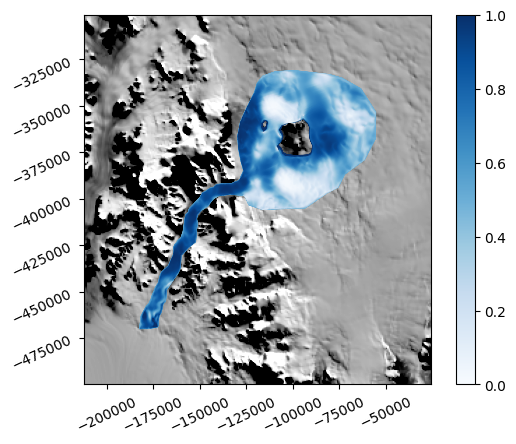

In [59]:


fig, axes = subplots()
colors = firedrake.tripcolor(
    ratio, vmin=0.0, vmax=1.0, cmap='Blues', axes=axes
)
fig.colorbar(colors);

